![](https://i.ibb.co/Zm9Rmdb/lung-nb4-short.jpg)

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 2.5em; font-weight: 300;">SIIM COVID-19 EffNetV2 Keras Study Level Train [TPU]</span></p>

<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Overview</span>

&nbsp;&nbsp;✅&nbsp;&nbsp;Training Official TF EfficientNetV2 Models on TPU [**CV AUC 0.804+**]<br>
&nbsp;&nbsp;✅&nbsp;&nbsp;Minimal Overhead TPU Augmentations<br>
&nbsp;&nbsp;✅&nbsp;&nbsp;Weights & Biases Integration<br>
<br>

**Please use v6 or above of this notebook, v4 or above of the TFHub Weight Files dataset and v6 or above of the inference notebook as some of the weight files are fixed.**

<br>

<p style='text-align: left;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.1em;"> 🏷️ Dataset with EffNetV2 TfHub Weights used in this notebook:</span></p>


>  [EfficientNetV2 TFHub Weight Files](https://www.kaggle.com/sreevishnudamodaran/efficientnetv2-tfhub-weight-files?select=tfhub_models)<br>
  Official EfficientNetV2 Saved Model Files from tfhub.dev

<br>

<p style='text-align: left;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.1em;"> 🏷️ Inference notebook for EffNetV2_L and Cascade RCNN:</span></p>

>[SIIM EffNetV2_L CascadeRCNN MMDetection Infer](https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer)
<br>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.6em;">References:</span>

- https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
- https://www.kaggle.com/h053473666/siim-covid19-efnb7-train-study
- https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
- https://github.com/google/automl/blob/master/efficientnetv2

<br>
<span style="color: #000508; font-family: Segoe UI; font-size: 1.3em;">Related Notebooks:</span>

EfficientNetV2 with Fastai:
[SIIM Covid19 Fastai+EfficientNetV2+TIMM Models💠🏮](https://www.kaggle.com/sreevishnudamodaran/siim-covid19-fastai-efficientnetv2-timm-models)

<br>
<a href="https://www.kaggle.com/sreevishnudamodaran"><center><img border="0" alt="Ask Me Something" src="https://img.shields.io/badge/Ask%20me-something-1abc9c.svg?style=flat-square&logo=kaggle" width="130" height="10"></center></a>
<br>
<center><img border="0" alt="Ask Me Something" src="https://img.shields.io/badge/Please-Upvote%20If%20you%20like%20this-07b3c8?style=for-the-badge&logo=kaggle" width="260" height="20"></center>

In [8]:
import itertools
import os
import random
import gc
import numpy as np
import pandas as pd
import math
import pprint
import matplotlib.pylab as plt
import seaborn as sns
sns.set(rc={"axes.titlesize":15, "axes.labelsize":9,"axes.titlepad":15,
            "axes.labelpad":12, "legend.fontsize":9,
            "legend.title_fontsize":9, "figure.titlesize":15,
            "axes.grid":False})

from sklearn.model_selection import train_test_split, GroupKFold
import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets

print('TF version:', tf.__version__)
print('Hub version:', tfhub.__version__)
print('Physical devices:', tf.config.list_physical_devices())

TF version: 2.4.1
Hub version: 0.12.0
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Data Loaders & Augmentations on TPU</span>

Thanks to [@cdeotte](https://www.kaggle.com/cdeotte) & [@xhlulu](https://www.kaggle.com/xhlulu)

In [9]:
SATURATION  = (0.9, 1.1)
CONTRAST = (0.9, 1.1)
BRIGHTNESS  =  0.1
ROTATION    = 10.0
SHEAR    = 2.0
HZOOM  = 8.0
WZOOM  = 4.0
HSHIFT = 4.0
WSHIFT = 4.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = cfg.input_dims[0]
    XDIM = DIM%2
    
    rot = ROTATION * tf.random.normal([1], dtype='float32')
    shr = SHEAR * tf.random.normal([1], dtype='float32')
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM
    h_shift = HSHIFT * tf.random.normal([1], dtype='float32')
    w_shift = WSHIFT * tf.random.normal([1], dtype='float32')
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot, shr, h_zoom, w_zoom, h_shift, w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]), label

In [10]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy


def build_decoder(with_labels=True, target_size=(256, 256), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)

        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_flip_up_down(img)
        img = tf.image.random_saturation(img, SATURATION[0], SATURATION[1])
        img = tf.image.random_contrast(img, CONTRAST[0], CONTRAST[1])
        img = tf.image.random_brightness(img, BRIGHTNESS)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, bsize=128, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024,
                  seed=None, cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    
    # Map the functions to perform Augmentations
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.map(transform, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle, seed=seed) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">📥 EffNetV2 Architecture Selection</span>

<br>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Segoe UI, sans-serif;font-size:160px;
  overflow:hidden;padding:20px 15px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Segoe UI, sans-serif;font-size:160px;
  font-weight:normal;overflow:hidden;padding:20px 15px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:centre;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky" style="font-size:16px;padding:5px 10px;text-align:center;font-family:Segoe UI;width:400px">Model Architecture</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-b0</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-b1</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-b2</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-b3</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-s</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-m</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-l</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-s-21k</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-m-21k</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-l-21k</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-s-21k-ft1k</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-m-21k-ft1k</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-l-21k-ft1k</td>
  </tr>
</tbody>
</table>

<br>

<span style="font-family: Segoe UI; font-size: 1.2em;">📌 The model architectures with <b>no suffixes</b> are pretrained on ImageNet1K. The ones with the <b>'21k'</b> as the suffix are pretrained on ImageNet21K and the ones with <b>'21k-ft1k'</b> as the suffix are pretrained on ImageNet21K and then finetuned on ImageNet1K.</span>

<br>

 **ImageNet1K pretrained and finetuned models:**

|      ImageNet1K   |     Top1 Acc.  |    Params   |  FLOPs   | Inference Latency | links  |
|    ----------     |      ------    |    ------   | ------  | ------   |   ------   |
|    EffNetV2-S     |    83.9%   |    21.5M    |  8.4B    | [V100/A100](g3doc/effnetv2-s-gpu.png) |  [ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-s.tgz),  [tensorboard](https://tensorboard.dev/experiment/wozwYcXkRPia76RopgCLlg)
|    EffNetV2-M     |    85.2%   |    54.1M    | 24.7B    | [V100/A100](g3doc/effnetv2-m-gpu.png) |  [ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-m.tgz),  [tensorboard](https://tensorboard.dev/experiment/syoaqB2gTP6Vr0KRlrezmg)
|    EffNetV2-L     |    85.7%   |   119.5M    | 56.3B    | [V100/A100](g3doc/effnetv2-l-gpu.png) |  [ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-l.tgz),  [tensorboard](https://tensorboard.dev/experiment/qgnTQ5JZQ92nSex6ZlWBbQ)

<br>

**Models Pretrained on ImageNet21K pretrained and finetuned with ImageNet1K:**


|  ImageNet21K  |  Pretrained models |  Finetuned ImageNet1K |
|  ----------   |  ------            |         ------       |
|  EffNetV2-S   |  [pretrain ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-s-21k.tgz)  |  top1=84.9%,  [ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-s-21k-ft1k.tgz),  [tensorboard](https://tensorboard.dev/experiment/7sga2olqTBeH4ioydel0hg/) |
|  EffNetV2-M   |  [pretrain ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-m-21k.tgz)  |  top1=86.2%,  [ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-m-21k-ft1k.tgz),  [tensorboard](https://tensorboard.dev/experiment/HkV6ANZSQ6WI5GhlZa48xQ/) |
|  EffNetV2-L   |  [pretrain ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-l-21k.tgz)  |  top1=86.9%,  [ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-l-21k-ft1k.tgz),  [tensorboard](https://tensorboard.dev/experiment/m9ZHx1L6SQu5iBYhXO5jOw/) |

<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Global Config & Seeding</span>

In [11]:
def seed_everything(SEED):
    os.environ['PYTHONHASHSEED']=str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)

In [12]:
class Config:
    seed = 333
    job = 1
    num_classes = 4
    input_dims = (768, 768)
    model_arch = "efficientnetv2-l-21k-ft1k" ## Choose model architecture
    batch_size = 8*16
    kfold = 5
    n_epochs = 15
    lr = 0.001
    loss_func = 'categorical_crossentropy'
    # Whether to finetune the whole model or just the top layer.
    fine_tune = True
    wandb_project = 'SIIM_classifier_public'
    dataset = "siim-covid19-images-metadata-256-512-768"
    
    seed_everything(seed)
    
cfg = Config()

<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">KFold Split</span>

In [13]:
# df = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
# df = pd.read_csv('../input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768/train_meta_768x768.csv')
df = pd.read_csv('../input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768/train_meta_768x768.csv')
study_df = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
study_df = study_df.rename({'id':'study_id'}, axis=1)
df['study_id'] = df['study_id']+ '_study'
df = pd.merge(df, study_df, on = 'study_id', how = 'left')

label_cols = ['Negative for Pneumonia','Typical Appearance',
            'Indeterminate Appearance','Atypical Appearance']

gkf  = GroupKFold(n_splits=cfg.kfold)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(df, groups=df.study_id.tolist())):
    df.loc[val_idx, 'fold'] = fold
    
df.to_csv('study_train_df.csv')
df.sample(3)

,id,folder_id,study_id,width,height,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,fold
4348,34b56732e1b2_image,cc0d7eb2ea8c,36d6d8418099_study,2220,2277,1,0,0,0,4
5505,364e2b97c131_image,8896c9291fc9,d0906bce2ac6_study,3000,2228,0,1,0,0,3
2076,70248cd9577f_image,6edba3a25a28,accb3f0a6276_study,2832,2320,0,0,1,0,4


<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🚀 Training</span>

We first find the GCS path of the selected EffNetV2 architecture from the EffNetV2 weights Kaggle dataset.

In [14]:
# Get the TensorFlow Hub model URL
hub_type = 'feature_vector' # ['classification', 'feature_vector']
# Get the GCS path of EfficientNet Models
DS_GCS_PATH = KaggleDatasets().get_gcs_path("efficientnetv2-tfhub-weight-files")
MODEL_GCS_PATH = f'{DS_GCS_PATH}/tfhub_models/{cfg.model_arch}/{hub_type}'
MODEL_GCS_PATH

'gs://kds-263da81de10c1bfa6df7fbf0f9e39c2d0ccbf462c3d4ff5fba365716/tfhub_models/efficientnetv2-l-21k-ft1k/feature_vector'

In [16]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_key") 
wandb.login(key=wandb_api)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
df

,id,folder_id,study_id,width,height,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,fold
0,d8ba599611e5_image,b2ee36aa2df5,cd5dd5e6f3f5_study,2836,2336,1,0,0,0,2
1,29b23a11d1e4_image,60a49211f5df,49358afcfb80_study,4256,3488,0,1,0,0,1
2,8174f49500a5_image,59f646771321,e4b50e7402c3_study,2846,2330,1,0,0,0,1
3,d54f6204b044_image,d289a11b2e85,e4b50e7402c3_study,2846,2330,1,0,0,0,1
4,d51cadde8626_image,60fe0c912619,92aad2d01be8_study,4256,3488,0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...
6329,729eca7b4c1c_image,710557945542,485d4ccd3c0e_study,3050,2539,1,0,0,0,4
6330,39d52f244db3_image,2f456f0b1367,59d10129bc08_study,2832,2320,0,1,0,0,2
6331,d342f75ccb55_image,2b3e1994f14b,59d10129bc08_study,2832,2320,0,1,0,0,2
6332,0f0b5a304a47_image,1784c7afd622,e6ade0ee672e_study,2832,2320,0,1,0,0,0


In [19]:
df[label_cols].values

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])


Fold: 0


wandb: Currently logged in as: wenbo-hu (use `wandb login --relogin` to force relogin)


Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
Train Job: efficientnetv2-l-21k-ft1k_fold0_job1 
Config
{'batch_size': 128,
 'dataset': 'siim-covid19-images-metadata-256-512-768',
 'fine_tune': 'True',
 'fold': 0,
 'input_dims': '(768, 768)',
 'job': 1,
 'job_name': 'efficientnetv2-l-21k-ft1k_fold0_job1',
 'kfold': 5,
 'loss_func': 'categorical_crossentropy',
 'lr': '0.001',
 'model_arch': 'efficientnetv2-l-21k-ft1k',
 'n_epochs': 15,
 'num_classes': 4,
 'seed': 333,
 'wandb_project': 'SIIM_classifier_public'}


wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/15
39/39 [==============================] - 517s 6s/step - loss: 1.3476 - accuracy: 0.4907 - auc: 0.6028 - val_loss: 1.1436 - val_accuracy: 0.5919 - val_auc: 0.7136
Epoch 2/15
39/39 [==============================] - 86s 2s/step - loss: 1.0232 - accuracy: 0.6005 - auc: 0.7122 - val_loss: 1.0357 - val_accuracy: 0.6243 - val_auc: 0.7633
Epoch 3/15
39/39 [==============================] - 86s 2s/step - loss: 0.9810 - accuracy: 0.6231 - auc: 0.7300 - val_loss: 0.9085 - val_accuracy: 0.6409 - val_auc: 0.7831
Epoch 4/15
39/39 [==============================] - 86s 2s/step - loss: 0.9740 - accuracy: 0.6244 - auc: 0.7411 - val_loss: 0.9444 - val_accuracy: 0.6377 - val_auc: 0.7783
Epoch 5/15
39/39 [==============================] - 85s 2s/step - loss: 0.9443 - accuracy: 0.6334 - auc: 0.7551 - val_loss: 0.8976 - val_accuracy: 0.6480 - val_auc: 0.7974
Epoch 6/15
39/39 [==============================] - 86s 2s/step - loss: 0.9127 - accuracy: 0.6440 - auc: 0.7771 - val_loss: 1.0223 - val_ac

epoch,14
loss,0.75172
accuracy,0.70473
auc,0.85267
val_loss,0.90605
val_accuracy,0.66062
val_auc,0.80865
_runtime,2053
_timestamp,1627369314
_step,14
best_val_loss,0.87561


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▄▄▄▄▄▃▃▂▂▂▁▂▁
accuracy,▁▄▅▅▅▅▅▆▆▇▇██▇█
auc,▁▄▄▄▅▅▅▆▇▇▇▇███
val_loss,█▅▂▃▂▅▇▄▁▁▁▁▁▂▂
val_accuracy,▂▅▆▆▆▂▁▃▇▇▇██▇▇
val_auc,▁▅▆▆▇▆▄▄▇████▇█
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


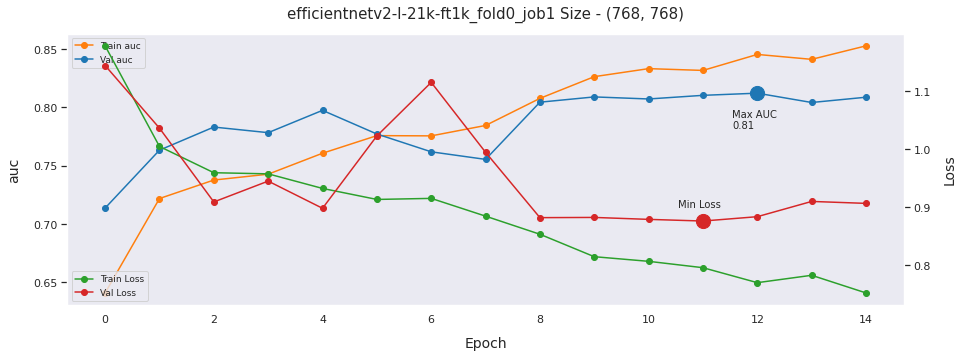


Fold: 1
Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
Train Job: efficientnetv2-l-21k-ft1k_fold1_job1 
Config
{'batch_size': 128,
 'dataset': 'siim-covid19-images-metadata-256-512-768',
 'fine_tune': 'True',
 'fold': 1,
 'input_dims': '(768, 768)',
 'job': 1,
 'job_name': 'efficientnetv2-l-21k-ft1k_fold1_job1',
 'kfold': 5,
 'loss_func': 'categorical_crossentropy',
 'lr': '0.001',
 'model_arch': 'efficientnetv2-l-21k-ft1k',
 'n_epochs': 15,
 'num_classes': 4,
 'seed': 333,
 'wandb_project': 'SIIM_classifier_public'}


wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/15
39/39 [==============================] - 461s 4s/step - loss: 1.3493 - accuracy: 0.4693 - auc: 0.5891 - val_loss: 1.1310 - val_accuracy: 0.6369 - val_auc: 0.7195
Epoch 2/15
39/39 [==============================] - 84s 2s/step - loss: 1.0333 - accuracy: 0.5912 - auc: 0.7053 - val_loss: 1.0106 - val_accuracy: 0.6259 - val_auc: 0.7340
Epoch 3/15
39/39 [==============================] - 83s 2s/step - loss: 0.9939 - accuracy: 0.6160 - auc: 0.7169 - val_loss: 0.9775 - val_accuracy: 0.6480 - val_auc: 0.7505
Epoch 4/15
39/39 [==============================] - 84s 2s/step - loss: 0.9775 - accuracy: 0.6247 - auc: 0.7359 - val_loss: 0.8966 - val_accuracy: 0.6575 - val_auc: 0.7775
Epoch 5/15
39/39 [==============================] - 85s 2s/step - loss: 0.9318 - accuracy: 0.6427 - auc: 0.7600 - val_loss: 0.9651 - val_accuracy: 0.6401 - val_auc: 0.7776
Epoch 6/15
39/39 [==============================] - 84s 2s/step - loss: 0.9354 - accuracy: 0.6423 - auc: 0.7621 - val_loss: 0.8894 - val_ac

epoch,14
loss,0.79401
accuracy,0.6905
auc,0.83856
val_loss,0.86894
val_accuracy,0.6693
val_auc,0.80389
_runtime,1899
_timestamp,1627371260
_step,14
best_val_loss,0.8586


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▄▄▄▄▃▃▃▂▂▁▁▁▁
accuracy,▁▄▅▅▆▅▆▅▆▇▇▇███
auc,▁▄▄▅▅▅▆▆▆▇▇████
val_loss,█▅▄▂▄▂▄▃▃▁▁▂▁▁▁
val_accuracy,▂▁▄▅▃▅▆▅▃██▇█▇▆
val_auc,▁▂▄▆▆▆▆▆▆██████
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


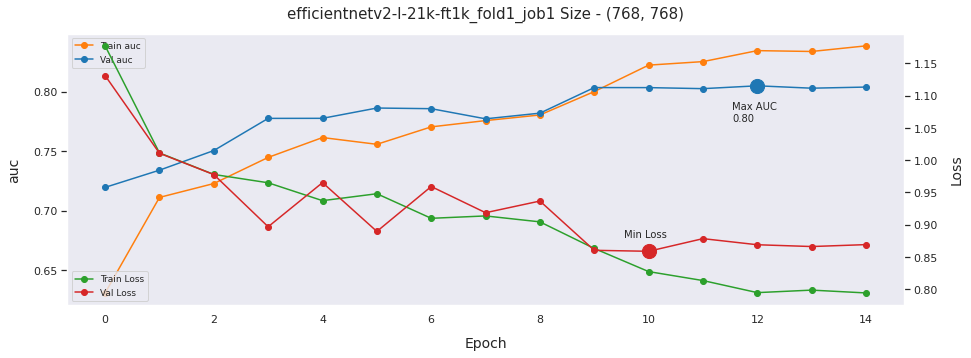


Fold: 2
Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
Train Job: efficientnetv2-l-21k-ft1k_fold2_job1 
Config
{'batch_size': 128,
 'dataset': 'siim-covid19-images-metadata-256-512-768',
 'fine_tune': 'True',
 'fold': 2,
 'input_dims': '(768, 768)',
 'job': 1,
 'job_name': 'efficientnetv2-l-21k-ft1k_fold2_job1',
 'kfold': 5,
 'loss_func': 'categorical_crossentropy',
 'lr': '0.001',
 'model_arch': 'efficientnetv2-l-21k-ft1k',
 'n_epochs': 15,
 'num_classes': 4,
 'seed': 333,
 'wandb_project': 'SIIM_classifier_public'}


wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/15
39/39 [==============================] - 447s 4s/step - loss: 1.3319 - accuracy: 0.4902 - auc: 0.6103 - val_loss: 1.1260 - val_accuracy: 0.6038 - val_auc: 0.7217
Epoch 2/15
39/39 [==============================] - 85s 2s/step - loss: 1.0417 - accuracy: 0.6093 - auc: 0.6948 - val_loss: 1.0554 - val_accuracy: 0.6243 - val_auc: 0.7531
Epoch 3/15
39/39 [==============================] - 83s 2s/step - loss: 0.9669 - accuracy: 0.6333 - auc: 0.7439 - val_loss: 1.0440 - val_accuracy: 0.6251 - val_auc: 0.7539
Epoch 4/15
39/39 [==============================] - 85s 2s/step - loss: 0.9502 - accuracy: 0.6375 - auc: 0.7511 - val_loss: 0.9311 - val_accuracy: 0.6472 - val_auc: 0.7790
Epoch 5/15
39/39 [==============================] - 84s 2s/step - loss: 0.9272 - accuracy: 0.6352 - auc: 0.7643 - val_loss: 1.0440 - val_accuracy: 0.5880 - val_auc: 0.7506
Epoch 6/15
39/39 [==============================] - 85s 2s/step - loss: 0.9291 - accuracy: 0.6485 - auc: 0.7606 - val_loss: 0.9220 - val_ac

epoch,14
loss,0.79028
accuracy,0.69491
auc,0.83845
val_loss,0.88541
val_accuracy,0.65588
val_auc,0.80677
_runtime,1903
_timestamp,1627373205
_step,14
best_val_loss,0.86962


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▅▄▄▃▄▃▃▂▂▁▁▁▁
accuracy,▁▄▄▅▅▆▅▆▆▇▇█▇██
auc,▁▃▄▅▅▅▅▆▆▇▇▇███
val_loss,█▆▆▃▆▂▃▃▇▁▁▁▂▁▁
val_accuracy,▃▅▅▇▁█▃▇▄▇██▇██
val_auc,▁▃▄▆▃▅▅▆▄██████
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


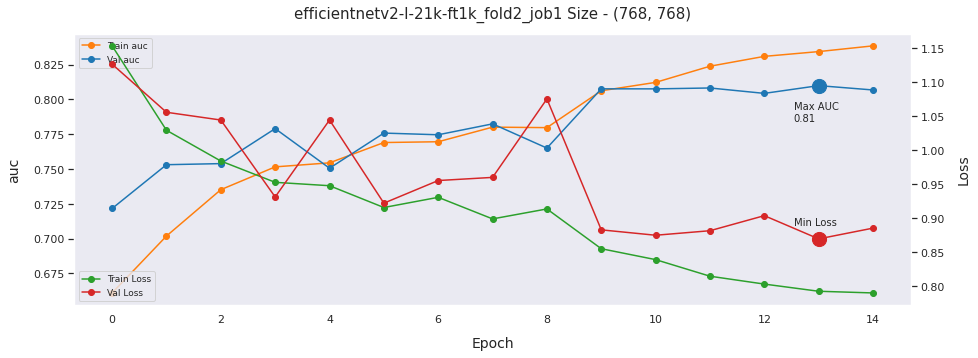


Fold: 3
Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
Train Job: efficientnetv2-l-21k-ft1k_fold3_job1 
Config
{'batch_size': 128,
 'dataset': 'siim-covid19-images-metadata-256-512-768',
 'fine_tune': 'True',
 'fold': 3,
 'input_dims': '(768, 768)',
 'job': 1,
 'job_name': 'efficientnetv2-l-21k-ft1k_fold3_job1',
 'kfold': 5,
 'loss_func': 'categorical_crossentropy',
 'lr': '0.001',
 'model_arch': 'efficientnetv2-l-21k-ft1k',
 'n_epochs': 15,
 'num_classes': 4,
 'seed': 333,
 'wandb_project': 'SIIM_classifier_public'}


wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/15
39/39 [==============================] - 446s 4s/step - loss: 1.2524 - accuracy: 0.4964 - auc: 0.6202 - val_loss: 0.9955 - val_accuracy: 0.6425 - val_auc: 0.7394
Epoch 2/15
39/39 [==============================] - 85s 2s/step - loss: 0.9965 - accuracy: 0.6183 - auc: 0.7192 - val_loss: 0.9761 - val_accuracy: 0.6117 - val_auc: 0.7645
Epoch 3/15
39/39 [==============================] - 84s 2s/step - loss: 0.9974 - accuracy: 0.6156 - auc: 0.7270 - val_loss: 0.9475 - val_accuracy: 0.6504 - val_auc: 0.7599
Epoch 4/15
39/39 [==============================] - 85s 2s/step - loss: 0.9557 - accuracy: 0.6243 - auc: 0.7543 - val_loss: 0.9093 - val_accuracy: 0.6496 - val_auc: 0.7806
Epoch 5/15
39/39 [==============================] - 84s 2s/step - loss: 0.9267 - accuracy: 0.6467 - auc: 0.7478 - val_loss: 0.9327 - val_accuracy: 0.6314 - val_auc: 0.7864
Epoch 6/15
39/39 [==============================] - 84s 2s/step - loss: 0.9208 - accuracy: 0.6414 - auc: 0.7679 - val_loss: 0.9386 - val_ac

epoch,14
loss,0.77853
accuracy,0.69591
auc,0.84487
val_loss,0.85247
val_accuracy,0.6693
val_auc,0.81715
_runtime,1894
_timestamp,1627375141
_step,14
best_val_loss,0.85247


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▅▅▄▄▄▄▃▃▃▂▁▁▁
accuracy,▁▄▄▄▅▅▅▆▆▅▆▇▇██
auc,▁▃▃▄▅▅▅▆▆▆▇▇███
val_loss,█▇▆▄▅▅▃▇▃▄▁▁▁▂▁
val_accuracy,▅▁▅▅▃▂▅▃▅▅███▇█
val_auc,▁▃▃▅▅▅▆▃▆▆▇█▇██
_runtime,▁▂▂▃▃▄▄▅▅▅▆▆▇██
_timestamp,▁▂▂▃▃▄▄▅▅▅▆▆▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


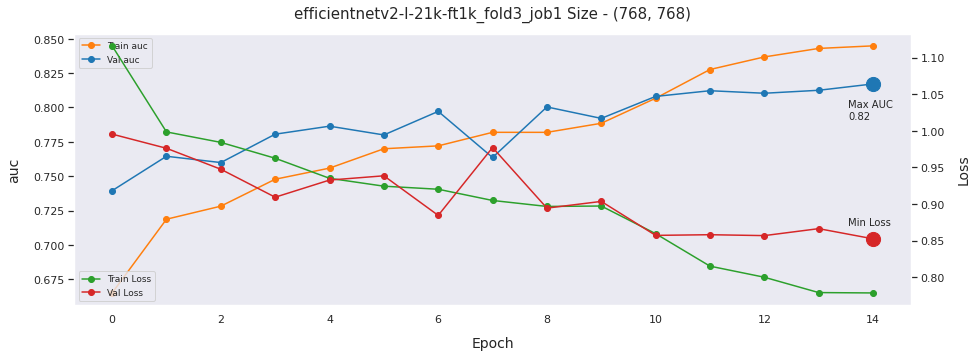


Fold: 4
Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
Train Job: efficientnetv2-l-21k-ft1k_fold4_job1 
Config
{'batch_size': 128,
 'dataset': 'siim-covid19-images-metadata-256-512-768',
 'fine_tune': 'True',
 'fold': 4,
 'input_dims': '(768, 768)',
 'job': 1,
 'job_name': 'efficientnetv2-l-21k-ft1k_fold4_job1',
 'kfold': 5,
 'loss_func': 'categorical_crossentropy',
 'lr': '0.001',
 'model_arch': 'efficientnetv2-l-21k-ft1k',
 'n_epochs': 15,
 'num_classes': 4,
 'seed': 333,
 'wandb_project': 'SIIM_classifier_public'}


wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/15
39/39 [==============================] - 445s 4s/step - loss: 1.2844 - accuracy: 0.5104 - auc: 0.5992 - val_loss: 0.9835 - val_accuracy: 0.6295 - val_auc: 0.7266
Epoch 2/15
39/39 [==============================] - 84s 2s/step - loss: 0.9980 - accuracy: 0.6125 - auc: 0.7152 - val_loss: 0.9120 - val_accuracy: 0.6461 - val_auc: 0.7739
Epoch 3/15
39/39 [==============================] - 85s 2s/step - loss: 0.9602 - accuracy: 0.6279 - auc: 0.7310 - val_loss: 1.0402 - val_accuracy: 0.5932 - val_auc: 0.7364
Epoch 4/15
39/39 [==============================] - 84s 2s/step - loss: 0.9705 - accuracy: 0.6178 - auc: 0.7427 - val_loss: 0.9911 - val_accuracy: 0.6469 - val_auc: 0.7648
Epoch 5/15
39/39 [==============================] - 84s 2s/step - loss: 0.9382 - accuracy: 0.6391 - auc: 0.7462 - val_loss: 0.9391 - val_accuracy: 0.6453 - val_auc: 0.7763
Epoch 6/15
39/39 [==============================] - 85s 2s/step - loss: 0.9174 - accuracy: 0.6442 - auc: 0.7732 - val_loss: 0.8843 - val_ac

epoch,14
loss,0.76975
accuracy,0.70212
auc,0.84521
val_loss,0.89906
val_accuracy,0.66351
val_auc,0.8033
_runtime,1832
_timestamp,1627377047
_step,14
best_val_loss,0.87208


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▅▄▄▃▃▂▂▂▁▂▁▁▁
accuracy,▁▄▅▅▅▆▆▇▇▇█▇█▇█
auc,▁▄▄▅▅▆▆▇▇▇█████
val_loss,▆▃█▆▄▂▁▂▁▂▂▃▂▂▂
val_accuracy,▄▆▁▆▆▇█▆██▇▇██▇
val_auc,▁▅▂▄▅▇███▇▇████
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


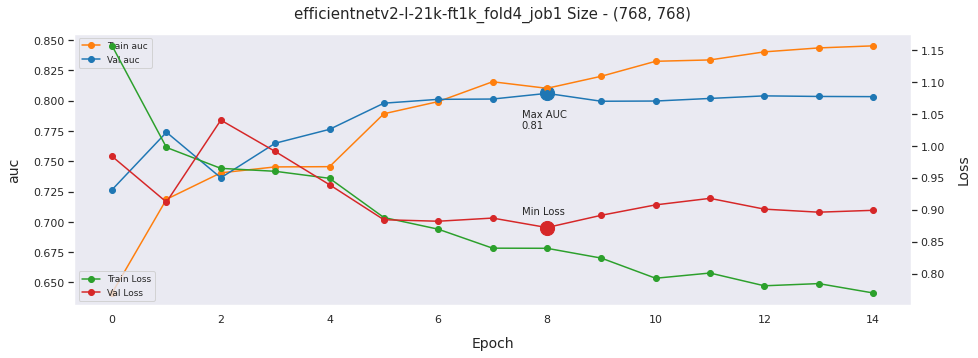


----------------------------------------
CV AUC: 0.8100249767303467
----------------------------------------


In [20]:
DISPLAY_PLOT = True
oof_aucs = dict()

# Get the GCS path of the images from the Kaggle dataset
GCS_DS_PATH = KaggleDatasets().get_gcs_path(cfg.dataset)

for fold in range(cfg.kfold):
    
    print("\nFold:", fold)
    
    # Define TPU strategy and clear TPU
    strategy = auto_select_accelerator()
    
    # Converting global config class object to a dictionary to log using Wandb
    config_dict = dict(vars(Config))
    config_dict = {k:(v if type(v)==int else str(v)) for (k,v) in config_dict.items() if '__' not in k}
    config_dict['fold'] = fold
    config_dict['job_name'] = f"{config_dict['model_arch']}_fold{fold}_job{config_dict['job']}"
    print("Train Job:", config_dict['job_name'], "\nConfig")
    pprint.pprint(config_dict)

    wandb.init(project=cfg.wandb_project, name=config_dict['job_name'], config=config_dict)

    valid_paths = GCS_DS_PATH + '/images_metadata_256_512_768/train_768x768/' + df[df['fold']==fold]['id'] + '.png' #"/train/"
    train_paths = GCS_DS_PATH + '/images_metadata_256_512_768/train_768x768/' + df[df['fold']!=fold]['id'] + '.png' #"/train/" 
    valid_labels = df[df['fold']==fold][label_cols].values
    train_labels = df[df['fold']!=fold][label_cols].values

    decoder = build_decoder(with_labels=True, target_size=cfg.input_dims, ext='png')
    test_decoder = build_decoder(with_labels=False, target_size=cfg.input_dims, ext='png')

    train_dataset = build_dataset(
        train_paths, train_labels, bsize=cfg.batch_size, decode_fn=decoder
    )

    valid_dataset = build_dataset(
        valid_paths, valid_labels, bsize=cfg.batch_size, decode_fn=decoder,
        repeat=False, shuffle=False, augment=False
    )

    num_classes = cfg.num_classes if cfg.num_classes else train_labels.shape[1]

    with strategy.scope():
        model = tf.keras.Sequential([
            # Explicitly define the input shape so the model can be properly
            # loaded by the TFLiteConverter
            tf.keras.layers.InputLayer(input_shape=[cfg.input_dims[0], cfg.input_dims[1], 3]),
            tfhub.KerasLayer(MODEL_GCS_PATH, trainable=cfg.fine_tune),
            tf.keras.layers.Dropout(rate=0.1),
            tf.keras.layers.Dense(num_classes,
                                  activation='softmax')
        ])

        model.build((None, cfg.input_dims[0], cfg.input_dims[1], 3))
#         model.summary()

        metrics = ['accuracy', tf.keras.metrics.AUC(name='auc', multi_label=True)]
        model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=cfg.lr),
          loss=cfg.loss_func,
          metrics=metrics)

    steps_per_epoch = train_paths.shape[0] // cfg.batch_size
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(f'model{fold}.h5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min'),
        wandb.keras.WandbCallback(save_model=True,
                      monitor='val_loss',
                      mode='min'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                             patience=3,
                                             min_lr=1e-6,
                                             mode='min'),
                ]

    history = model.fit(
        train_dataset, 
        epochs=cfg.n_epochs,
        verbose=1,
        callbacks=callbacks,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_dataset)

    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f'history{fold}.csv')

    del decoder, test_decoder, train_dataset, valid_dataset, model
    gc.collect()

    oof_aucs[fold] = float(np.max(history.history['val_auc']))
    print("oof_aucs", oof_aucs)
    
    wandb.finish()
    
    # Plot Training History
    if DISPLAY_PLOT:
        print ("\n\n")
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(history.history['auc'])), history.history['auc'],
                 '-o', label='Train auc', color='#ff7f0e')
        plt.plot(np.arange(len(history.history['auc'])), history.history['val_auc'],
                 '-o', label='Val auc', color='#1f77b4')
        x = np.argmax(history.history['val_auc'])
        y = np.max(history.history['val_auc'])
        xdist = plt.xlim()[1] - plt.xlim()[0]
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200, color='#1f77b4')
        plt.text(x-0.03*xdist, y-0.13*ydist, 'Max AUC\n%.2f'%y, size=10)
        plt.ylabel('auc', size=14)
        plt.xlabel('Epoch', size=14)
        plt.legend(loc=2)

        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(len(history.history['auc'])),
                  history.history['loss'],'-o', label='Train Loss', color='#2ca02c')
        plt2.plot(np.arange(len(history.history['auc'])),
                  history.history['val_loss'],'-o', label='Val Loss', color='#d62728')
        x = np.argmin(history.history['val_loss'])
        y = np.min(history.history['val_loss'])
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x, y, s=200, color='#d62728')
        plt.text(x-0.03*xdist, y+0.05*ydist,'Min Loss', size=10)
        plt.ylabel('Loss', size=14)
        plt.title(f"{config_dict['job_name']} Size - {cfg.input_dims}")
        plt.legend(loc=3)
        plt.savefig(f'fig{fold}.png')
        plt.show()
        
print("\n"+"-"*40)
print("CV AUC:", sum(list(oof_aucs.values()))/cfg.kfold)
print("-"*40)

In [21]:
!rm -r /kaggle/working/wandb

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 2.7em; font-weight: 300;">HAVE A GREAT DAY!</span></p>

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.3em; font-weight: 300;">Let me know if you have any suggestions!</span></p>